## ЛР 7
## (Медведев К.В. М8О-406Б-21)

### Проведение исследований моделями семантической сегментации


**План работ:**

1. Выбор начальных условий:
    - Выбрать набор данных для задачи классификации
    - Выбрать метрики качества и обосновать их выбор

2. Создание бейзлайна и оценка качества:
    - Обучить модели segmentation_models.pytorch
    - Оценить качество моделей по выбранным метрикам на выбранном наборе данных

3. Улучшение бейзлайна:
    - Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)
    - Проверить гипотезы
    - Сформировать улучшенный бейзлайн по результатам проверки гипотез
    - Обучить модели с улучшенным бейзлайном на выбранном наборе данных
    - Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных

4. Имплементация алгоритма машинного обучения:
    - Самостоятельно имплементировать модели машинного обучения
    - Обучить имплементированные модели на выбранном наборе данных
    - Оценить качество имплементированных моделей
    - Добавить техники из улучшенного бейзлайна
    - Обучить модели для выбранных наборов данных
    - Оценить качество моделей
5. 	Сделать выводы




# 1. Выбор начальных условий

Загрузка датасета

In [1]:
import kagglehub
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Загрузка датасета
path = kagglehub.dataset_download("ihelon/football-player-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/football-player-segmentation


In [2]:
# Устанавливаем пути к фотографиям и аннотациям для них (Бинарным маскам)
img_path = str(path) + "/images/"
annotations_path = str(path) + "/annotations/instances_default.json"

INPUT_SIZE = (1920, 1080)
IMG_SIZE = 512
N = 512

with open(annotations_path) as f:
    annotations = json.load(f)

`COCO (Common Objects in Context)` — это формат аннотаций для датасетов, включающий информацию об изображениях, объектах на них, их сегментации, координатах и классах.

Из JSON-файла в формате COCO извлекаются ID изображений и соответствующие им имена файлов, чтобы позже можно было легко сопоставить аннотацию с конкретным изображением.

In [3]:
image_id_dict = {image['id']: image['file_name'] for image in annotations['images']}

Далее создаются бинарные маски для каждого изображения, где закрашиваются области, соответствующие сегментациям объектов (игроков) из аннотаций COCO.

Для каждого изображения маска сначала рисуется по полигонам в исходном размере, затем масштабируется до размера модели и сохраняется в массив `masks` как булевый массив с каналом.

In [4]:
masks = np.zeros((N, IMG_SIZE, IMG_SIZE), dtype=bool)

# Создание масок по аннотациям
for annotation in annotations['annotations']:
    img_id = annotation['image_id']

    mask = Image.new('1', INPUT_SIZE)
    mask_draw = ImageDraw.Draw(mask)

    for segmentation in annotation['segmentation']:
        polygon = np.array(segmentation).reshape((-1, 2))
        mask_draw.polygon([tuple(point) for point in polygon], fill=1)

    bool_array = np.array(mask.resize((IMG_SIZE, IMG_SIZE))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array

masks = masks.reshape(N, IMG_SIZE, IMG_SIZE, 1)

На изображениях отображаются футбольные фотографии, поверх которых полупрозрачно наложены маски объектов (игроков), выделенные фиолетовым цветом. Это позволяет визуально оценить качество сегментации — какие области изображения модель должна распознавать как объекты.

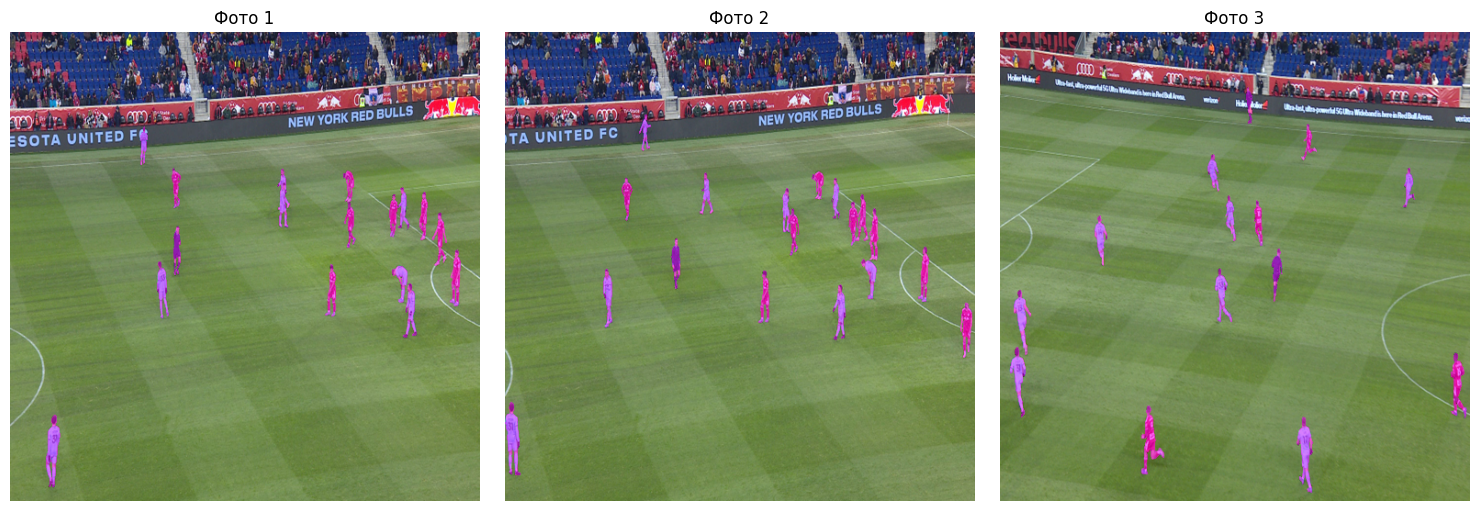

In [5]:
def visualize_masks_overlay(img_dir, masks, image_id_dict, num_images=5, alpha=0.5):
    plt.figure(figsize=(15, 5))

    shown = 0
    for idx, (img_id, file_name) in enumerate(image_id_dict.items()):
        if shown >= num_images:
            break
        img_path_full = os.path.join(img_dir, file_name)

        if not os.path.exists(img_path_full):
            continue

        img = Image.open(img_path_full).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        img_np = np.array(img)

        mask = masks[img_id - 1].squeeze()
        if mask.max() == 0:
            continue

        red_mask = np.zeros_like(img_np, dtype=np.uint8)
        red_mask[mask] = [255, 0, 255]  # Фиолетовый цвет для маски

        blended = img_np.copy()
        blended[mask] = (alpha * red_mask[mask] + (1 - alpha) * img_np[mask]).astype(np.uint8)

        plt.subplot(1, num_images, shown + 1)
        plt.imshow(blended)
        plt.title(f"Фото {img_id}")
        plt.axis('off')
        shown += 1

    plt.tight_layout()
    plt.show()

visualize_masks_overlay(img_path, masks, image_id_dict, num_images=3)


Для оценки качества сегментации объектов на изображениях использованы две метрики:
- **Intersection over Union (IoU)**
- **Коэффициент Dice**.

**IoU** измеряет долю пересечения предсказанной маски и истинной маски относительно их объединения:

$$
\text{IoU} = \frac{|P \cap G|}{|P \cup G|} = \frac{\text{intersection}}{\text{union}}
$$

где:
- \( P \) — бинарная предсказанная маска,
- \( G \) — бинарная истинная маска.

**Dice-мера** фокусируется на перекрытии между предсказанием и истинной маской и более чувствительна к небольшим объектам:

$$
\text{Dice} = \frac{2 |P \cap G|}{|P| + |G|}
$$

In [6]:
# Расчет Intersection over Union (IoU)
def calculate_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    masks = masks.float()

    intersection = torch.sum(preds * masks)  # Пересечение
    union = torch.sum(preds) + torch.sum(masks) - intersection  # Объединение

    if union == 0:
        return 0.0

    iou = intersection / union
    return iou.item()

# Расчет коэффициента Dice
def calculate_dice(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    masks = masks.float()

    intersection = torch.sum(preds * masks)
    dice = (2 * intersection) / (torch.sum(preds) + torch.sum(masks))

    if torch.sum(preds) + torch.sum(masks) == 0:
        return 0.0

    return dice.item()

# 2. Создание бейзлайна и оценка качества

Реализация обучения модели сегментации изображений с использованием PyTorch и PyTorch Lightning. Используется архитектура U-Net с энкодером ResNet34, предварительно обученным на ImageNet. Данные загружаются из кастомного датасета `FootballDataset`, где изображения и соответствующие маски сегментации преобразуются и подаются в DataLoader для пакетной обработки.

Модель обучается с функцией потерь Dice Loss, оптимизатором Adam и метриками качества сегментации — метрикой Jaccard (IoU) и коэффициентом Dice. Обучение и валидация проходят с логированием значений потерь и метрик.

**U-Net** - архитектура нейронной сети для сегментации изображений, состоящая из симметричного энкодера (сжатие признаков) и декодера (восстановление пространственной информации) с пропускными связями (skip connections).

**Dice Loss** - функция потерь, основанная на коэффициенте Dice, измеряет степень совпадения между предсказанной маской и истинной маской. Полезна для задач сегментации с несбалансированными классами.

Шаги выполнения:
1. Подготовка и разбиение данных на обучающую и валидационную выборки.
2. Определение кастомного датасета `FootballDataset` для загрузки изображений и масок.
3. Создание модели U-Net с ResNet34 энкодером.
4. Объявление функции потерь и метрик (Dice Loss, IoU, Dice Coefficient).
5. Обучение модели с логированием метрик и потерь.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp
import pytorch_lightning as pl

from torchmetrics.classification import JaccardIndex  # IoU метрика

# Установка параметров
BATCH_SIZE = 8
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Датасет
class FootballDataset(Dataset):
    def __init__(self, image_ids, masks, img_dir, transform=None):
        self.image_ids = image_ids
        self.masks = masks
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_name = image_id_dict[img_id]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        mask = self.masks[img_id - 1]

        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask = Image.fromarray(mask * 255).resize((IMG_SIZE, IMG_SIZE))

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        mask = np.array(mask) / 255
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
])

all_ids = list(image_id_dict.keys())
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

train_dataset = FootballDataset(train_ids, masks, img_path, transform=transform)
val_dataset = FootballDataset(val_ids, masks, img_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Модель
class UNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.metric_iou = JaccardIndex(task="binary").to(device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)

        preds = torch.sigmoid(logits) > 0.5
        iou = self.metric_iou(preds.int(), y.int())
        self.log('train_iou', iou, prog_bar=True)

        dice = self.dice_coeff(preds, y)
        self.log('train_dice', dice, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        preds = torch.sigmoid(logits) > 0.5
        iou = self.metric_iou(preds.int(), y.int())
        self.log('val_iou', iou, prog_bar=True)

        dice = self.dice_coeff(preds, y)
        self.log('val_dice', dice, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    @staticmethod
    def dice_coeff(preds, targets, smooth=1e-6):
        preds = preds.float()
        targets = targets.float()
        intersection = (preds * targets).sum(dim=[1, 2, 3])
        union = preds.sum(dim=[1, 2, 3]) + targets.sum(dim=[1, 2, 3])
        dice = (2 * intersection + smooth) / (union + smooth)
        return dice.mean()

# Обучение модели
model = UNetLightning()
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=True,
    enable_progress_bar=True
)


trainer.fit(model, train_loader, val_loader)


# 3. Улучшение бейзлайна

В улучшенном бейзлайне была добавлена аугментация изображений с помощью библиотеки Albumentations, включающая такие преобразования, как случайное горизонтальное отражение, изменение яркости и контраста, сдвиги, масштабирование и повороты, а также нормализация под статистику ImageNet и преобразование в тензоры. Эти аугментации применяются только к обучающему набору и синхронизированы с соответствующими масками.

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torchmetrics.classification import JaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

# Загрузка датасета
path = kagglehub.dataset_download("ihelon/football-player-segmentation")
img_path = str(path) + "/images/"
annotations_path = str(path) + "/annotations/instances_default.json"

INPUT_SIZE = (1920, 1080)
IMG_SIZE = 512
N = 512

with open(annotations_path) as f:
    annotations = json.load(f)

image_id_dict = {image['id']: image['file_name'] for image in annotations['images']}

masks = np.zeros((N, IMG_SIZE, IMG_SIZE), dtype=bool)

for annotation in annotations['annotations']:
    img_id = annotation['image_id']
    mask = Image.new('1', INPUT_SIZE)
    mask_draw = ImageDraw.Draw(mask)

    for segmentation in annotation['segmentation']:
        polygon = np.array(segmentation).reshape((-1, 2))
        mask_draw.polygon([tuple(point) for point in polygon], fill=1)

    bool_array = np.array(mask.resize((IMG_SIZE, IMG_SIZE))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array

masks = masks.reshape(N, IMG_SIZE, IMG_SIZE, 1)

# Аугментации
IMAGE_SIZE = 512

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Dataset
class FootballDataset(Dataset):
    def __init__(self, image_ids, masks, img_dir, transform=None):
        self.image_ids = image_ids
        self.masks = masks
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_name = image_id_dict[img_id]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        image = image.resize((IMG_SIZE, IMG_SIZE))

        image = np.array(image)
        mask = self.masks[img_id - 1].squeeze().astype('float32')
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask

# Разделение данных
all_ids = list(image_id_dict.keys())
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

train_dataset = FootballDataset(train_ids, masks, img_path, transform=train_transform)
val_dataset = FootballDataset(val_ids, masks, img_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Модель Lightning
class UNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.metric_iou = JaccardIndex(task="binary").to(self.device)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)

        preds = torch.sigmoid(logits) > 0.5
        iou = self.metric_iou(preds.int(), y.int())
        self.log('train_iou', iou, prog_bar=True)

        dice = self.dice_coeff(preds, y)
        self.log('train_dice', dice, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        preds = torch.sigmoid(logits) > 0.5
        iou = self.metric_iou(preds.int(), y.int())
        self.log('val_iou', iou, prog_bar=True)

        dice = self.dice_coeff(preds, y)
        self.log('val_dice', dice, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    @staticmethod
    def dice_coeff(preds, targets, smooth=1e-6):
        preds = preds.float()
        targets = targets.float()
        intersection = (preds * targets).sum(dim=[1, 2, 3])
        union = preds.sum(dim=[1, 2, 3]) + targets.sum(dim=[1, 2, 3])
        dice = (2 * intersection + smooth) / (union + smooth)
        return dice.mean()

# Обучение модели
model = UNetLightning()
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=True,
    enable_progress_bar=True
)

trainer.fit(model, train_loader, val_loader)


# 4. Имплементация алгоритма машинного обучения

Загрузка и масштабирование изображений до фиксированного размера

In [7]:
images = np.zeros((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for img_id, img_filename in image_id_dict.items():
    img = Image.open(os.path.join(img_path, img_filename))
    img = img.resize((IMG_SIZE, IMG_SIZE))
    images[img_id - 1] = img

Архитектура `UNet` реализует U-образную нейронную сеть для задач сегментации изображений. Она состоит из двух основных частей:

- **Сжимающий путь (Encoder):** последовательно применяются блоки сверточных слоев `conv_block`, каждый из которых удваивает количество каналов и уменьшает разрешение изображения через `max_pool2d`.

- **Боттлнек:** центральный слой с наибольшим числом каналов (2048), связывающий энкодер и декодер.

- **Восстанавливающий путь (Decoder):** используется транспонированная свертка (`ConvTranspose2d`) для увеличения пространственного разрешения, после чего результат объединяется (`concat`) с соответствующим уровнем энкодера и обрабатывается сверточным блоком.

- **Выходной слой:** `Conv2d` с ядром 1×1 и `sigmoid`, предсказывающий вероятности принадлежности к целевому классу (для бинарной сегментации).

Модель предназначена для сегментации изображений, обладает глубокой структурой (5 уровней + bottleneck) и симметричным строением с пропускными соединениями.


In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting path (Encoder)
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)  # Additional layer

        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048)

        # Expanding path (Decoder)
        self.upconv5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(2048, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        # Final output layer (binary segmentation)
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block

    def forward(self, x):
        # Encoder (contracting path)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))
        enc5 = self.encoder5(F.max_pool2d(enc4, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc5, kernel_size=2))

        # Decoder (expanding path)
        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((enc5, dec5), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final output
        return torch.sigmoid(self.conv_last(dec1))

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Класс `SegmentationDataset` представляет собой пользовательский датасет для задачи семантической сегментации. Он принимает изображения и соответствующие маски, а также необязательные трансформации. В методе `__getitem__` изображения и маски преобразуются в тензоры PyTorch, нормализуются и приводятся к формату `[C, H, W]`.

После определения датасета данные разбиваются на обучающую и валидационную выборки с помощью `train_test_split`, и на их основе создаются `DataLoader`-ы с пакетной подачей данных (`batch_size=8`) и перемешиванием (`shuffle=True` для train).


In [10]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images  # Image data
        self.masks = masks    # Mask data
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Fetch the image
        mask = self.masks[idx]    # Fetch the corresponding mask

        # Convert to torch tensors
        image = torch.from_numpy(image).to(torch.float32) / 255.0  # Normalize image to [0, 1]
        mask = torch.from_numpy(mask).to(torch.float32)

        # Change dimension order from [H, W, C] to [C, H, W]
        image = image.permute(2, 0, 1)
        mask = mask.permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Initialize datasets and data loaders
train_dataset = SegmentationDataset(images=train_images, masks=train_masks)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = SegmentationDataset(images=val_images, masks=val_masks)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Данный код реализует цикл обучения модели сегментации в течение 10 эпох. На каждой эпохе происходит:

1. **Обучающая фаза**:
   - Модель переводится в режим обучения (`model.train()`).
   - Для каждого батча:
     - Выполняется прямой проход (`forward`), расчет функции потерь (`loss`), обратный проход (`backward`) и обновление весов (`optimizer.step()`).
   - Сохраняется среднее значение потерь за эпоху.

2. **Фаза валидации**:
   - Модель переводится в режим оценки (`model.eval()`), отключается вычисление градиентов (`torch.no_grad()`).
   - Для каждого батча:
     - Вычисляется функция потерь, метрики качества сегментации: IoU и Dice.
   - Рассчитываются средние значения по эпохе.

После каждой эпохи результаты сохраняются в списки `train_loss_list`, `val_loss_list`, `iou_list` и `dice_list`, и выводятся на экран.


In [11]:
num_epochs = 10

train_loss_list = []
val_loss_list = []
iou_list = []
dice_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()  # Convert masks to float

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate IoU and Dice Coefficient
            iou = calculate_iou(outputs, masks)
            dice = calculate_dice(outputs, masks)

            iou_total += iou
            dice_total += dice

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou_total / len(val_loader)
    avg_dice = dice_total / len(val_loader)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    iou_list.append(avg_iou)
    dice_list.append(avg_dice)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"IoU: {avg_iou:.4f}, Dice Coefficient: {avg_dice:.4f}")

Epoch [1/10]
Training Loss: 0.3774, Validation Loss: 0.1115
IoU: 0.0000, Dice Coefficient: 0.0000
Epoch [2/10]
Training Loss: 0.1071, Validation Loss: 0.1163
IoU: 0.0000, Dice Coefficient: 0.0000
Epoch [3/10]
Training Loss: 0.0938, Validation Loss: 0.0857
IoU: 0.0000, Dice Coefficient: 0.0000
Epoch [4/10]
Training Loss: 0.0644, Validation Loss: 0.0440
IoU: 0.0000, Dice Coefficient: 0.0000
Epoch [5/10]
Training Loss: 0.0311, Validation Loss: 0.0256
IoU: 0.6609, Dice Coefficient: 0.7956
Epoch [6/10]
Training Loss: 0.0227, Validation Loss: 0.0202
IoU: 0.6911, Dice Coefficient: 0.8172
Epoch [7/10]
Training Loss: 0.0182, Validation Loss: 0.0171
IoU: 0.7233, Dice Coefficient: 0.8393
Epoch [8/10]
Training Loss: 0.0161, Validation Loss: 0.0160
IoU: 0.7301, Dice Coefficient: 0.8439
Epoch [9/10]
Training Loss: 0.0145, Validation Loss: 0.0133
IoU: 0.7677, Dice Coefficient: 0.8685
Epoch [10/10]
Training Loss: 0.0124, Validation Loss: 0.0131
IoU: 0.7780, Dice Coefficient: 0.8751


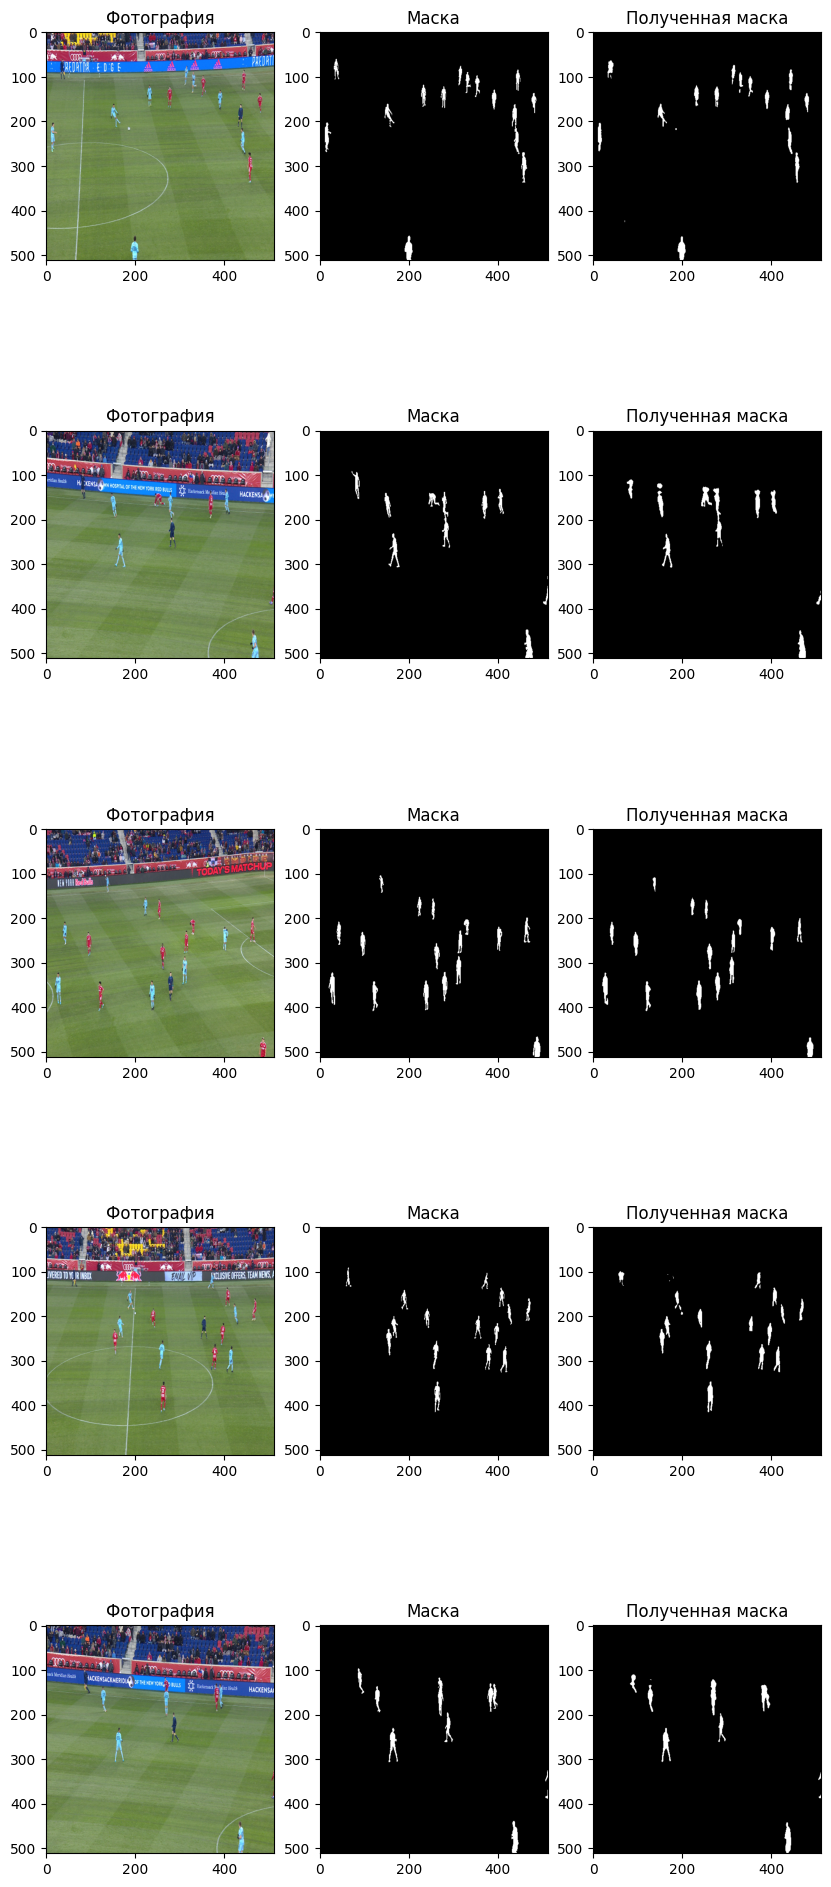

In [14]:
def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots(num_images, 3, figsize=(10, num_images * 5))

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)


            outputs = model(images)

            for i in range(images.size(0)):
                if images_so_far == num_images:
                    return

                pred_mask = (outputs[i] > 0.5).float()
                true_mask = masks[i]

                ax[images_so_far, 0].imshow(images[i].cpu().permute(1, 2, 0))
                ax[images_so_far, 0].set_title('Фотография')

                ax[images_so_far, 1].imshow(true_mask.cpu().squeeze(), cmap='gray')
                ax[images_so_far, 1].set_title('Маска')

                ax[images_so_far, 2].imshow(pred_mask.cpu().squeeze(), cmap='gray')
                ax[images_so_far, 2].set_title('Полученная маска')

                images_so_far += 1

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device, num_images=5)